# FIBAD Demonstration

For this demonstration we'll walk through a simplified version of a typical machine learning workflow supported by FIBAD.

In [1]:
import fibad
import pooch
import subprocess

import chromadb
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from IPython.display import IFrame

from fibad.config_utils import find_most_recent_results_dir
from mpr_demo_plotting import sort_objects_by_median_distance, plot_grid, plot_umap

## Download a sample HSC dataset

In [1]:
file_path = pooch.retrieve(
    # DOI for Example HSC dataset
    url="doi:10.5281/zenodo.14498536/hsc_demo_data.zip",
    known_hash="md5:1be05a6b49505054de441a7262a09671",
    fname="example_hsc_new.zip",
    path="../../data",
    processor=pooch.Unzip(extract_dir="."),
)

This dataset is comprised of approximately 993 cutouts from the Hyper Suprime Cam survey.
Each cutout includes i, r and g bands and is 8 arcseconds on a side.


## Create and configure a FIBAD object

In [2]:
f = fibad.Fibad()

[2025-02-08 10:07:31,029 fibad:INFO] Runtime Config read from: /home/drew/code/fibad/src/fibad/fibad_default_config.toml


An instance of the `Fibad` class will be used through out this demo.
Under the hood when it is created, it will:
-  Load the configuration file specified (here it's using the built in default).
-  Parse the configuration file for external libraries and add those to the appropriate registries.
-  Prepare logging for the system.

In [7]:
# Specify the location of the data to use for training
f.config["general"]["data_dir"] = "../../data/hsc_8asec_1000_bu"

# Specify the dataset class that represents the data
f.config["data_set"]["name"] = "HSCDataSet"
f.config["data_set"]["train_size"] = 0.8
f.config["data_set"]["validate_size"] = 0.2
f.config["data_set"]["test_size"] = 0.0

# Select the model to use for training
f.config["model"]["name"] = "ExampleAutoencoder"

# Set the number of epochs and batch size for training.
f.config["train"]["epochs"] = 20
f.config["data_loader"]["batch_size"] = 32

The default configuration needs a few tweaks to work for this demo.
We've updated the location of our sample data, and specified which model we want to train.

The configuration is represented as nested python dictionary. This allows for easy manipulation in a notebook via the `.config` attribute of the fibad instance.

## Train a model

In [8]:
f.train()

[2025-02-04 16:14:57,477 fibad.data_sets.hsc_data_set:INFO] Processed 993 objects for pruning


[2025-02-04 16:14:57,478 fibad.data_sets.hsc_data_set:INFO] Checking file dimensions to determine standard cutout size...
[2025-02-04 16:14:57,481 fibad.data_sets.hsc_data_set:INFO] HSC Data set loader has 993 objects
[2025-02-04 16:14:57,483 fibad.data_sets.hsc_data_set:INFO] test split contains 0 items
[2025-02-04 16:14:57,484 fibad.data_sets.hsc_data_set:INFO] train split contains 794 items
[2025-02-04 16:14:57,485 fibad.data_sets.hsc_data_set:INFO] validate split contains 199 items
[2025-02-04 16:14:57,498 fibad.models.model_registry:INFO] Using criterion: torch.nn.CrossEntropyLoss with default arguments.
2025-02-04 16:14:57,572 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<fibad.data_sets.hsc': 
	{'sampler': <torch.utils.data.sampler.SubsetRandomSampler object at 0x7fbe1bb94cb0>, 'batch_size': 32, 'num_workers': 2, 'pin_memory': True}
2025-02-04 16:14:57,574 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<fiba

  4%|4         | 1/25 [00:00<?, ?it/s]

  4%|4         | 1/25 [00:00<?, ?it/s]

  4%|4         | 1/25 [00:00<?, ?it/s]

  4%|4         | 1/25 [00:00<?, ?it/s]

  4%|4         | 1/25 [00:00<?, ?it/s]

  4%|4         | 1/25 [00:00<?, ?it/s]

  4%|4         | 1/25 [00:00<?, ?it/s]

  4%|4         | 1/25 [00:00<?, ?it/s]

  4%|4         | 1/25 [00:00<?, ?it/s]

  4%|4         | 1/25 [00:00<?, ?it/s]

  4%|4         | 1/25 [00:00<?, ?it/s]

  4%|4         | 1/25 [00:00<?, ?it/s]

  4%|4         | 1/25 [00:00<?, ?it/s]

  4%|4         | 1/25 [00:00<?, ?it/s]

  4%|4         | 1/25 [00:00<?, ?it/s]

  4%|4         | 1/25 [00:00<?, ?it/s]

  4%|4         | 1/25 [00:00<?, ?it/s]

  4%|4         | 1/25 [00:00<?, ?it/s]

  4%|4         | 1/25 [00:00<?, ?it/s]

  4%|4         | 1/25 [00:00<?, ?it/s]

[2025-02-04 16:15:48,162 fibad.pytorch_ignite:INFO] Total training time: 50.33[s]
[2025-02-04 16:15:48,163 fibad.pytorch_ignite:INFO] Latest checkpoint saved as: /home/drew/code/fibad/docs/pre_executed/results/20250204-161457-train-GFb1/checkpoint_epoch_20.pt
[2025-02-04 16:15:48,163 fibad.pytorch_ignite:INFO] Best metric checkpoint saved as: /home/drew/code/fibad/docs/pre_executed/results/20250204-161457-train-GFb1/checkpoint_20_loss=-170.9727.pt
2025/02/04 16:15:48 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2025/02/04 16:15:48 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
[2025-02-04 16:15:48,210 fibad.train:INFO] Finished Training


When we call `.train()` to train the model there's a lot going on under the hood:
- The model is automatically loaded onto the fastest hardware available.
- A data loader is instantiated and configured to load batches of data to the same hardware.
- A new timestamped directory is created under the configured results directory where all output is saved.
- The configuration becomes immutable and a copy is saved for reproducibility.
- The model and system metrics start being logged for review in both TensorBoard and MLFlow.
- Checkpoints are saved automatically both at the last epoch and at the epoch with the lowest loss value.
- Finally the model weights file is saved.

Training time depends heavily on the hardware available, model, and training parameters.
For a point of reference training takes about 40s for this case:
- Model trained: Built in autoencoder
- Dataset and size: Example HSC data, 993 samples, 96x96 pixel cutouts
- Number of epochs: 20
- Batch size: 32
- Hardware: Desktop with GTX 1660 Super GPU

While we train on only about 1000 samples here, FIBAD training has scaled up to over 1M samples on an HPC system with access to multiple GPUs without requiring the user to make any code changes.
To do so, the command line interface of FIBAD was used to work within a Slurm environment like so:
```
>> fibad train --runtime-config ./results/<timestamped_directory>/runtime_config.toml
```

## Quickly evaluate the model

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir {f.config['general']['results_dir']}

The preceding cell will start TensorBoard, to perform simple evaluation of trained models. While TensorBoard can run easily in a notebook, when that notebook is rendered to HTML (for demonstration or documentation) the server backing the TensorBoard UI isn't included in the rendering. If the cell above was run locally, the resulting UI would look similar to the following screen shot.

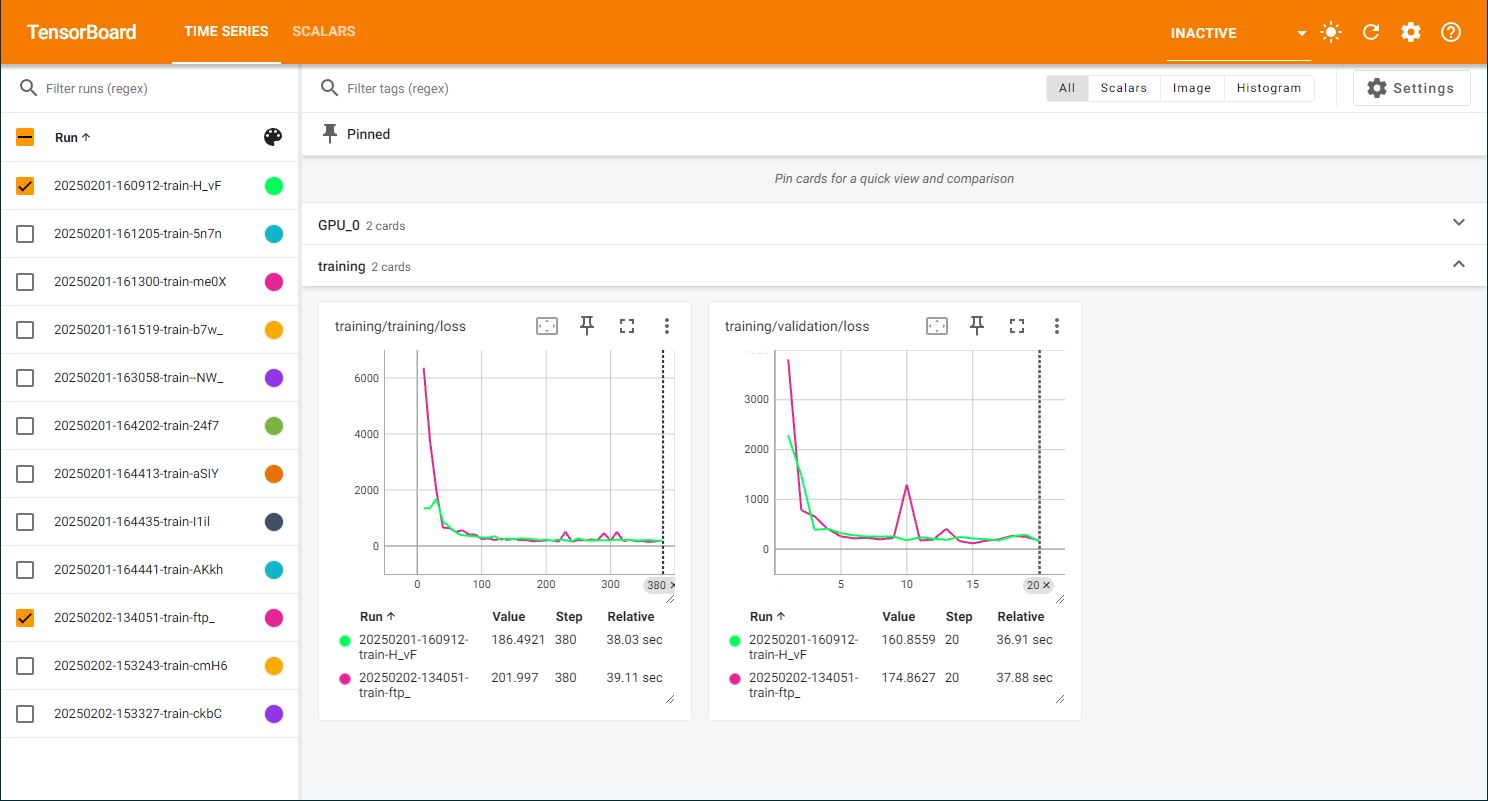

## Create a new model

In [6]:
import torch.nn as nn
from fibad.models.model_registry import fibad_model


@fibad_model  # This decorator registers the model with the FIBAD framework
class TrialAutoencoder(nn.Module):
    def __init__(self, config, shape):
        super().__init__()
        self.config = config

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),  # (16, 48, 48)
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # (32, 24, 24)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # (64, 12, 12)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # (128, 6, 6)
            nn.ReLU(),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # (64, 12, 12)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # (32, 24, 24)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # (16, 48, 48)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # (3, 96, 96)
            nn.Sigmoid(),  # Normalize output to [0, 1]
        )

    def _eval_encoder(self, x):
        return self.encoder(x)

    def _eval_decoder(self, x):
        return self.decoder(x)

    def forward(self, x):
        return self._eval_encoder(x)

    def train_step(self, x):
        z = self._eval_encoder(x)
        x_hat = self._eval_decoder(z)

        loss = self.criterion(x, x_hat)
        loss = loss.sum(dim=[1, 2, 3]).mean(dim=[0])
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return {"loss": loss.item()}

New models can be written in a notebook for easier experimentation.
Above, an autoencoder is written for comparison against the builtin `ExampleAutoencoder` where the only difference is that the builtin autoencoder uses `nn.GeLU` while `nn.ReLU` is used here.

Note that the class is decorated with `@fibad_model`, this decorator automatically provides several conveniences for the user:
- The model class is registered with FIBAD for training.
- Default loss and optimizer functions are provided.
- Support for defining loss and optimizer functions in the FIBAD configuration.
- Methods to save and load model weights are provided included.
- Automatic verification that required methods were implemented.

In addition to the `@fibad_model`, other decorators to support extensibility and reduce boilerplate code have been developed including:
- `@fibad_dataset` - for rapid development of new data set interfaces
- `@fibad_verb` - for new core actions i.e. `f.custom_train(...)`, `f.bespoke_predict(...)`, etc.


## Train the newly defined model

In [7]:
# Specify that we now want to train the model defined in this notebook
f.config["model"]["name"] = "TrialAutoencoder"

# Define loss and optimizer functions for easy experimentation
f.config["criterion"]["name"] = "torch.nn.MSELoss"
f.config["torch.nn.MSELoss"] = {"reduction": "none"}

f.config["optimizer"]["name"] = "torch.optim.Adam"
f.config["torch.optim.Adam"] = {"lr": 1e-3}

# train the new model
f.train()

[2025-02-02 15:33:27,040 fibad.data_sets.hsc_data_set:INFO] Processed 993 objects for pruning
[2025-02-02 15:33:27,041 fibad.data_sets.hsc_data_set:INFO] Checking file dimensions to determine standard cutout size...
[2025-02-02 15:33:27,044 fibad.data_sets.hsc_data_set:INFO] HSC Data set loader has 993 objects
[2025-02-02 15:33:27,048 fibad.data_sets.hsc_data_set:INFO] test split contains 199 items
[2025-02-02 15:33:27,048 fibad.data_sets.hsc_data_set:INFO] train split contains 596 items
[2025-02-02 15:33:27,049 fibad.data_sets.hsc_data_set:INFO] validate split contains 198 items
[2025-02-02 15:33:27,053 fibad.models.model_registry:INFO] Using criterion: torch.nn.MSELoss with arguments: {'reduction': 'none'}.
[2025-02-02 15:33:27,054 fibad.models.model_registry:INFO] Using optimizer: torch.optim.Adam with arguments: {'lr': 0.001}.
2025-02-02 15:33:27,055 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<fibad.data_sets.hsc': 
	{'sampler': <torch.utils.d

  5%|5         | 1/19 [00:00<?, ?it/s]

  5%|5         | 1/19 [00:00<?, ?it/s]

  5%|5         | 1/19 [00:00<?, ?it/s]

  5%|5         | 1/19 [00:00<?, ?it/s]

  5%|5         | 1/19 [00:00<?, ?it/s]

  5%|5         | 1/19 [00:00<?, ?it/s]

  5%|5         | 1/19 [00:00<?, ?it/s]

  5%|5         | 1/19 [00:00<?, ?it/s]

  5%|5         | 1/19 [00:00<?, ?it/s]

  5%|5         | 1/19 [00:00<?, ?it/s]

  5%|5         | 1/19 [00:00<?, ?it/s]

  5%|5         | 1/19 [00:00<?, ?it/s]

  5%|5         | 1/19 [00:00<?, ?it/s]

  5%|5         | 1/19 [00:00<?, ?it/s]

  5%|5         | 1/19 [00:00<?, ?it/s]

  5%|5         | 1/19 [00:00<?, ?it/s]

  5%|5         | 1/19 [00:00<?, ?it/s]

  5%|5         | 1/19 [00:00<?, ?it/s]

  5%|5         | 1/19 [00:00<?, ?it/s]

  5%|5         | 1/19 [00:00<?, ?it/s]

[2025-02-02 15:34:06,556 fibad.pytorch_ignite:INFO] Total training time: 39.48[s]
[2025-02-02 15:34:06,558 fibad.pytorch_ignite:INFO] Latest checkpoint saved as: /home/drew/code/fibad/docs/pre_executed/results/20250202-153327-train-ckbC/checkpoint_epoch_20.pt
[2025-02-02 15:34:06,558 fibad.pytorch_ignite:INFO] Best metric checkpoint saved as: /home/drew/code/fibad/docs/pre_executed/results/20250202-153327-train-ckbC/checkpoint_19_loss=-137.0688.pt
2025/02/02 15:34:06 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2025/02/02 15:34:06 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
[2025-02-02 15:34:06,600 fibad.train:INFO] Finished Training


Note the adjustments that were made to `f.config` before beginning the training.
First the model name is updated to be the name of the new model class defined in this notebook.
Recall that the `@fibad_model` decorator will register the model with FIBAD, this is what allows us to refer to the model by the class name.

Additionally we defined the loss and optimizer functions in the config to be used by the model.
FIBAD supports this feature to allow easy experimentation and evaluation of the performance of these hyperparameters.

All of the same actions are being taken as before when we call `f.train()`.
Recall that under the hood FIBAD is:
- Identifying and using the most performant hardware available to train.
- Creating a new timestamped directory where all output is saved.
- Freezing the configuration and saving a copy for reproducibility.
- Logging model and system metrics for review in both TensorBoard and MLFlow.
- Generating checkpoints automatically both at the last epoch and at the epoch with the lowest loss value.
- Saving the model weights file.

## Compare multiple models

In [6]:
# Start the MLFlow UI server
backend_store_uri = f"file://{Path(f.config['general']['results_dir']).resolve() / 'mlflow'}"
mlflow_ui_process = subprocess.Popen(
    ["mlflow", "ui", "--backend-store-uri", backend_store_uri, "--port", "8080"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
)

# Display the MLFlow UI in an IFrame in the notebook
IFrame(src="http://localhost:8080", width="100%", height=1000)

FIBAD automatically logs training information for model evaluation.
Here we see an in-notebook instance of the MLFlow UI.
Typically, the UI would be started from the command line and viewed in a browser to avoid having to scroll back and forth in a notebook.
The typical command to do so would look like: `mlflow ui --backend-store-uri <results_directory/mlflow>`

While MLFlow can run in a notebook, when that notebook is rendered to HTML (for demonstration or documentation) the server backing the MLFlow UI isn't included in the rendering. If the cell above was run locally, the resulting UI would look similar to the following screen shot.

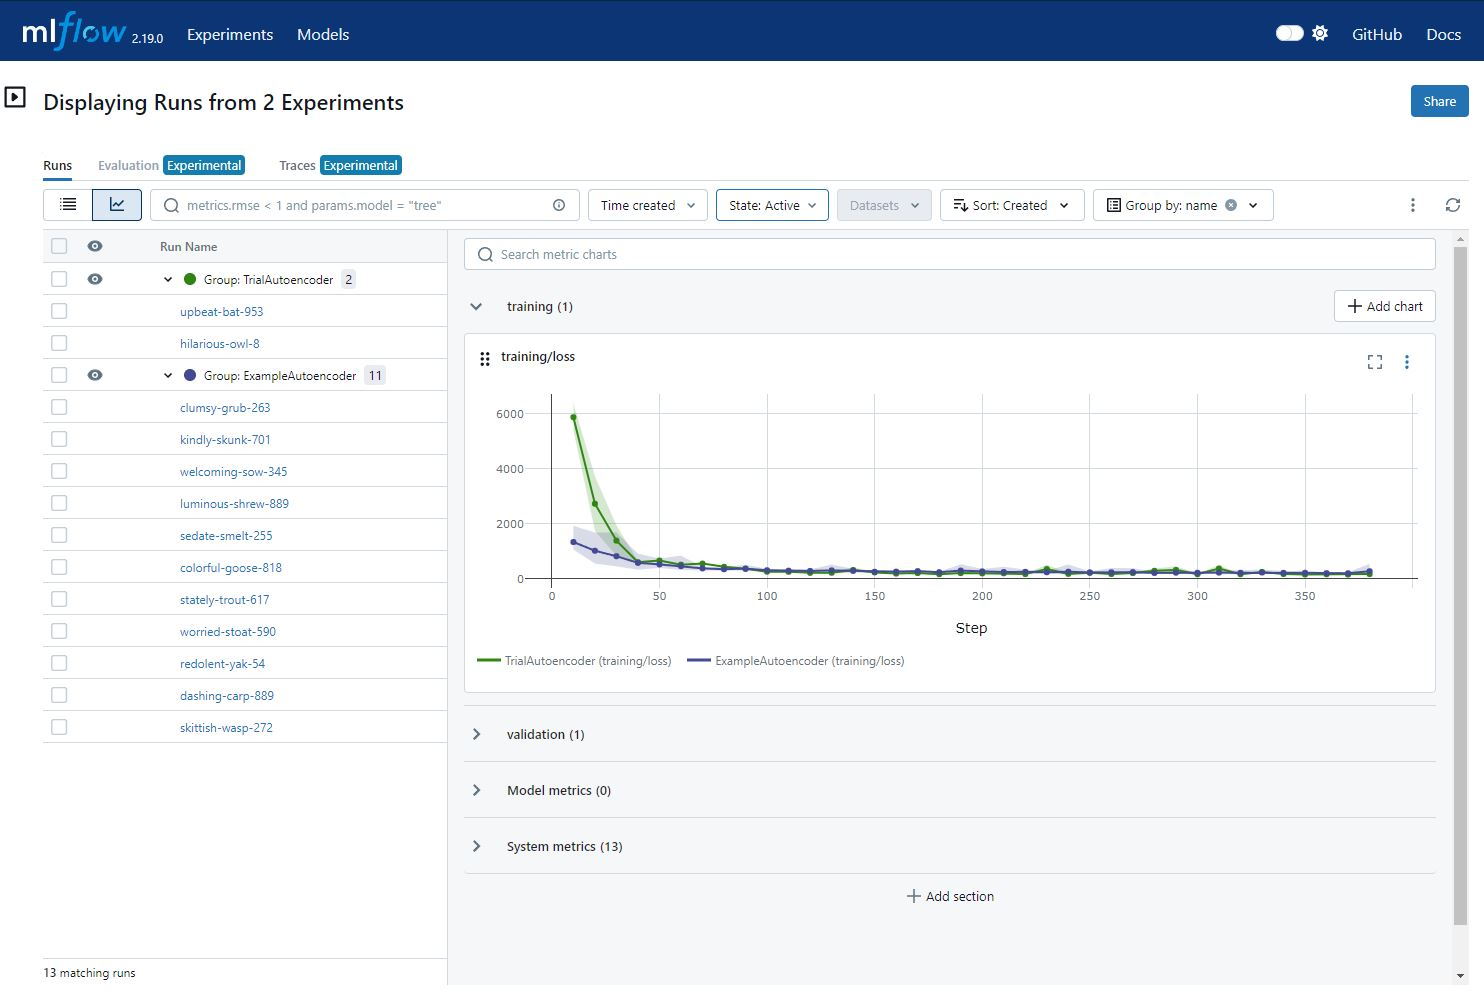

## Running inference

In [9]:
# Update the data set splits to be 100% test data
f.config["data_set"]["test_size"] = 1.0
f.config["data_set"]["train_size"] = 0.0
f.config["data_set"]["validate_size"] = 0.0

# Increase batch size for faster inference
f.config["data_loader"]["batch_size"] = 512

# Run inference
f.infer()

[2025-02-04 16:16:02,914 fibad.data_sets.hsc_data_set:INFO] Processed 993 objects for pruning
[2025-02-04 16:16:02,915 fibad.data_sets.hsc_data_set:INFO] Checking file dimensions to determine standard cutout size...
[2025-02-04 16:16:02,918 fibad.data_sets.hsc_data_set:INFO] HSC Data set loader has 993 objects
[2025-02-04 16:16:02,920 fibad.data_sets.hsc_data_set:INFO] test split contains 993 items
[2025-02-04 16:16:02,921 fibad.data_sets.hsc_data_set:INFO] train split contains 0 items
[2025-02-04 16:16:02,930 fibad.models.model_registry:INFO] Using criterion: torch.nn.CrossEntropyLoss with default arguments.
[2025-02-04 16:16:02,931 fibad.infer:INFO] data set has length 993
2025-02-04 16:16:02,932 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<fibad.data_sets.hsc': 
	{'sampler': None, 'batch_size': 512, 'num_workers': 2, 'pin_memory': True}
[2025-02-04 16:16:03,272 fibad.pytorch_ignite:INFO] Evaluating model on device: cuda
[2025-02-04 16:16:03,273 

For this demo, we'll pretend that of all the models we trained, the last one performed best.
We'll now use that model to run inference.
Note that by default, FIBAD will find the weights of the last successfully trained model for inference, but of course, a different set of weights can be specified in the configuration.

First we make a small update to the data set splits, setting `test_size` to 100% and the other splits to 0%.
We also increase the batch size in order to make better use of the available GPU memory.

Finally we run inference over the dataset using the trained model weights with `f.infer()`.
As with training, FIBAD is doing a lot behind the scenes on behalf of the user including:
- Identifying and using the most performant hardware available.
- Creating a new timestamped directory where all output is saved.
- Freezing the configuration and saving a copy for reproducibility.
- Saving the results of inference in batched .npy files.
- Optionally persisting the results to a vector database.

Again, while predicting the latent space for only 1000 samples here, FIBAD inference has scaled up to over 1M samples on an HPC system with access to multiple GPUs without requiring any code changes.

## Exploring the results of inference

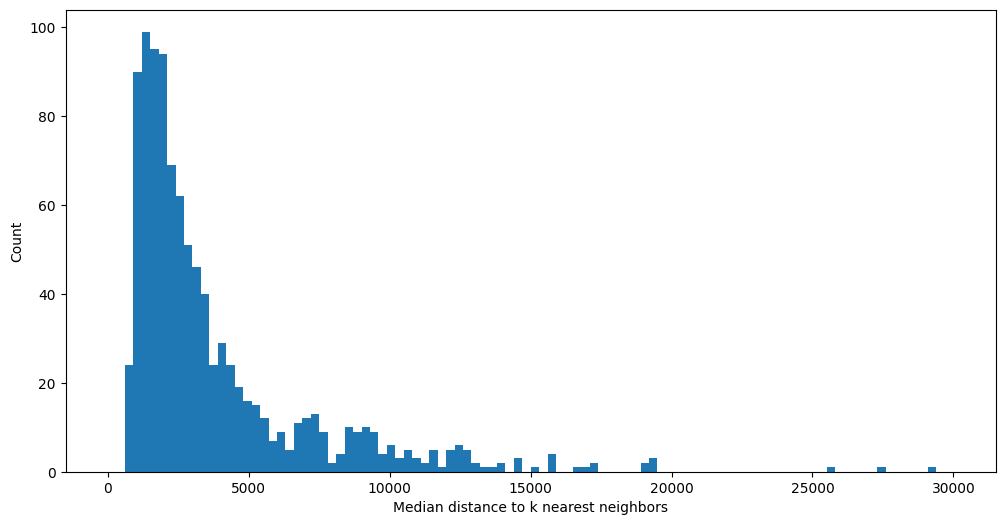

In [4]:
# Establish a connection to the database containing the inference results
results_dir = find_most_recent_results_dir(f.config, "infer")
client = chromadb.PersistentClient(path=str(results_dir))
collection = client.get_collection("fibad")

# For each entry in the database, find the L2 norm distance to the k nearest neighbors
all_embeddings = collection.get(include=["embeddings"])
all_nn = collection.query(query_embeddings=all_embeddings["embeddings"], n_results=5)

# Calculate the median distance to the k nearest neighbor for each entry
median_dist_all_nn = np.median(all_nn["distances"], axis=1)

# Plot a histogram of the median distances
plt.figure(figsize=(12, 6))
plt.hist(median_dist_all_nn, bins=100, range=(0, 30_000))
plt.xlabel("Median distance to k nearest neighbors")
plt.ylabel("Count")
plt.show()

With inference complete, we can begin to explore the results.
Here we make use of the built in vector database that enables fast, approximate, similarity search.
The vector database was populated automatically while running inference.

> Aside: What is a "vector database"?
>
> A vector database is one which is optimized to store vectors and maintains an index that can be exploited to provide rapid look up of similar vectors.
> The similarity between vectors is defined by the distance between them, where the definition of distance is configurable.
> By default, FIBAD uses squared L2 norm.
> Thus, given a latent space vector for a given object, the database provides an efficient way to find the k most similar vectors.

By making use of our vector database, we have:
- Efficiently found the L2 norm distance to each of the k nearest neighbors for every vector produced by inference.
- Calculated the median of the distances to the k nearest neighbors.
- Plotted the histogram of those median values.

There appears to be a long tail in the distribution of values, indicating that there are a small number of objects with latent space vectors that have median L2 norm distances much greater than the average.

## Examine a few objects

In [5]:
sorted_object = sort_objects_by_median_distance(
    all_embeddings, median_dist_all_nn, data_directory=f.config["general"]["data_dir"]
)

Here we order the results of the median calculation and transform the results a bit to make it easier to visualize (gather filename and median distance values for plotting).
Next we plot the first and last 16 objects in the sorted list.
The first 16 objects are those that correspond to near the peak of the histogram.
The last 16 objects are those in the long tail of the histgram.

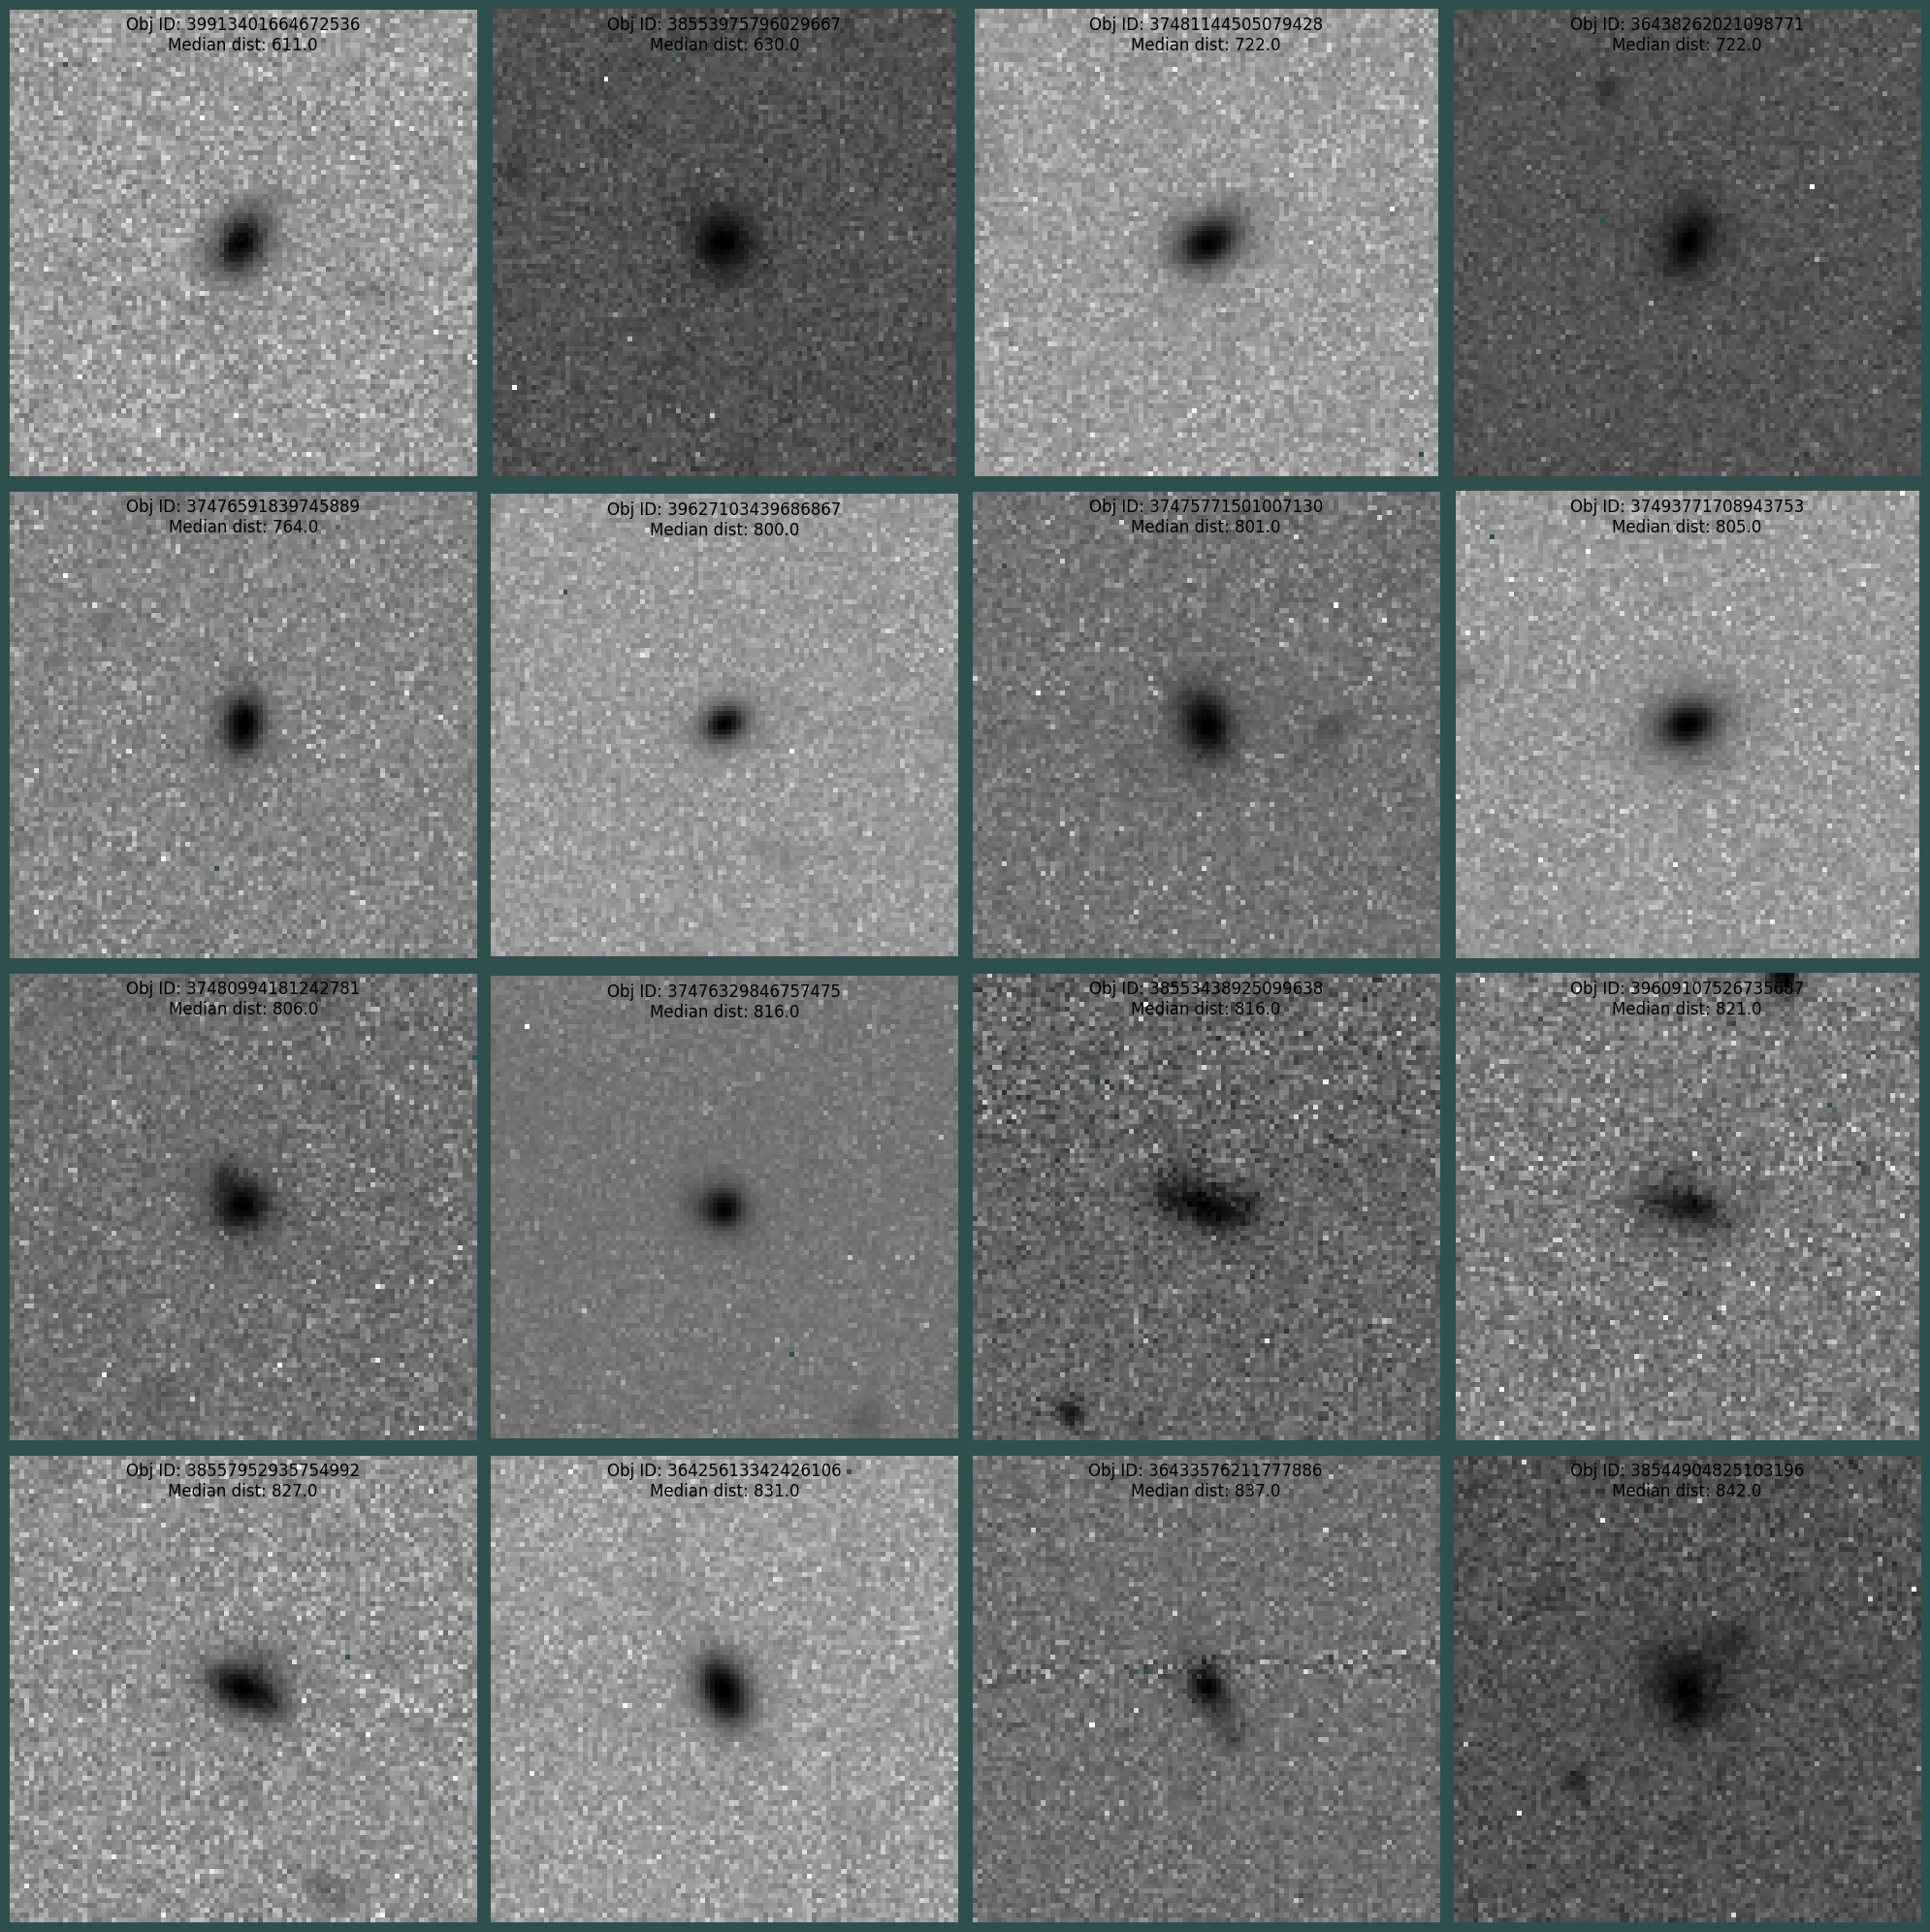

In [6]:
plot_grid(sorted_object[:16])

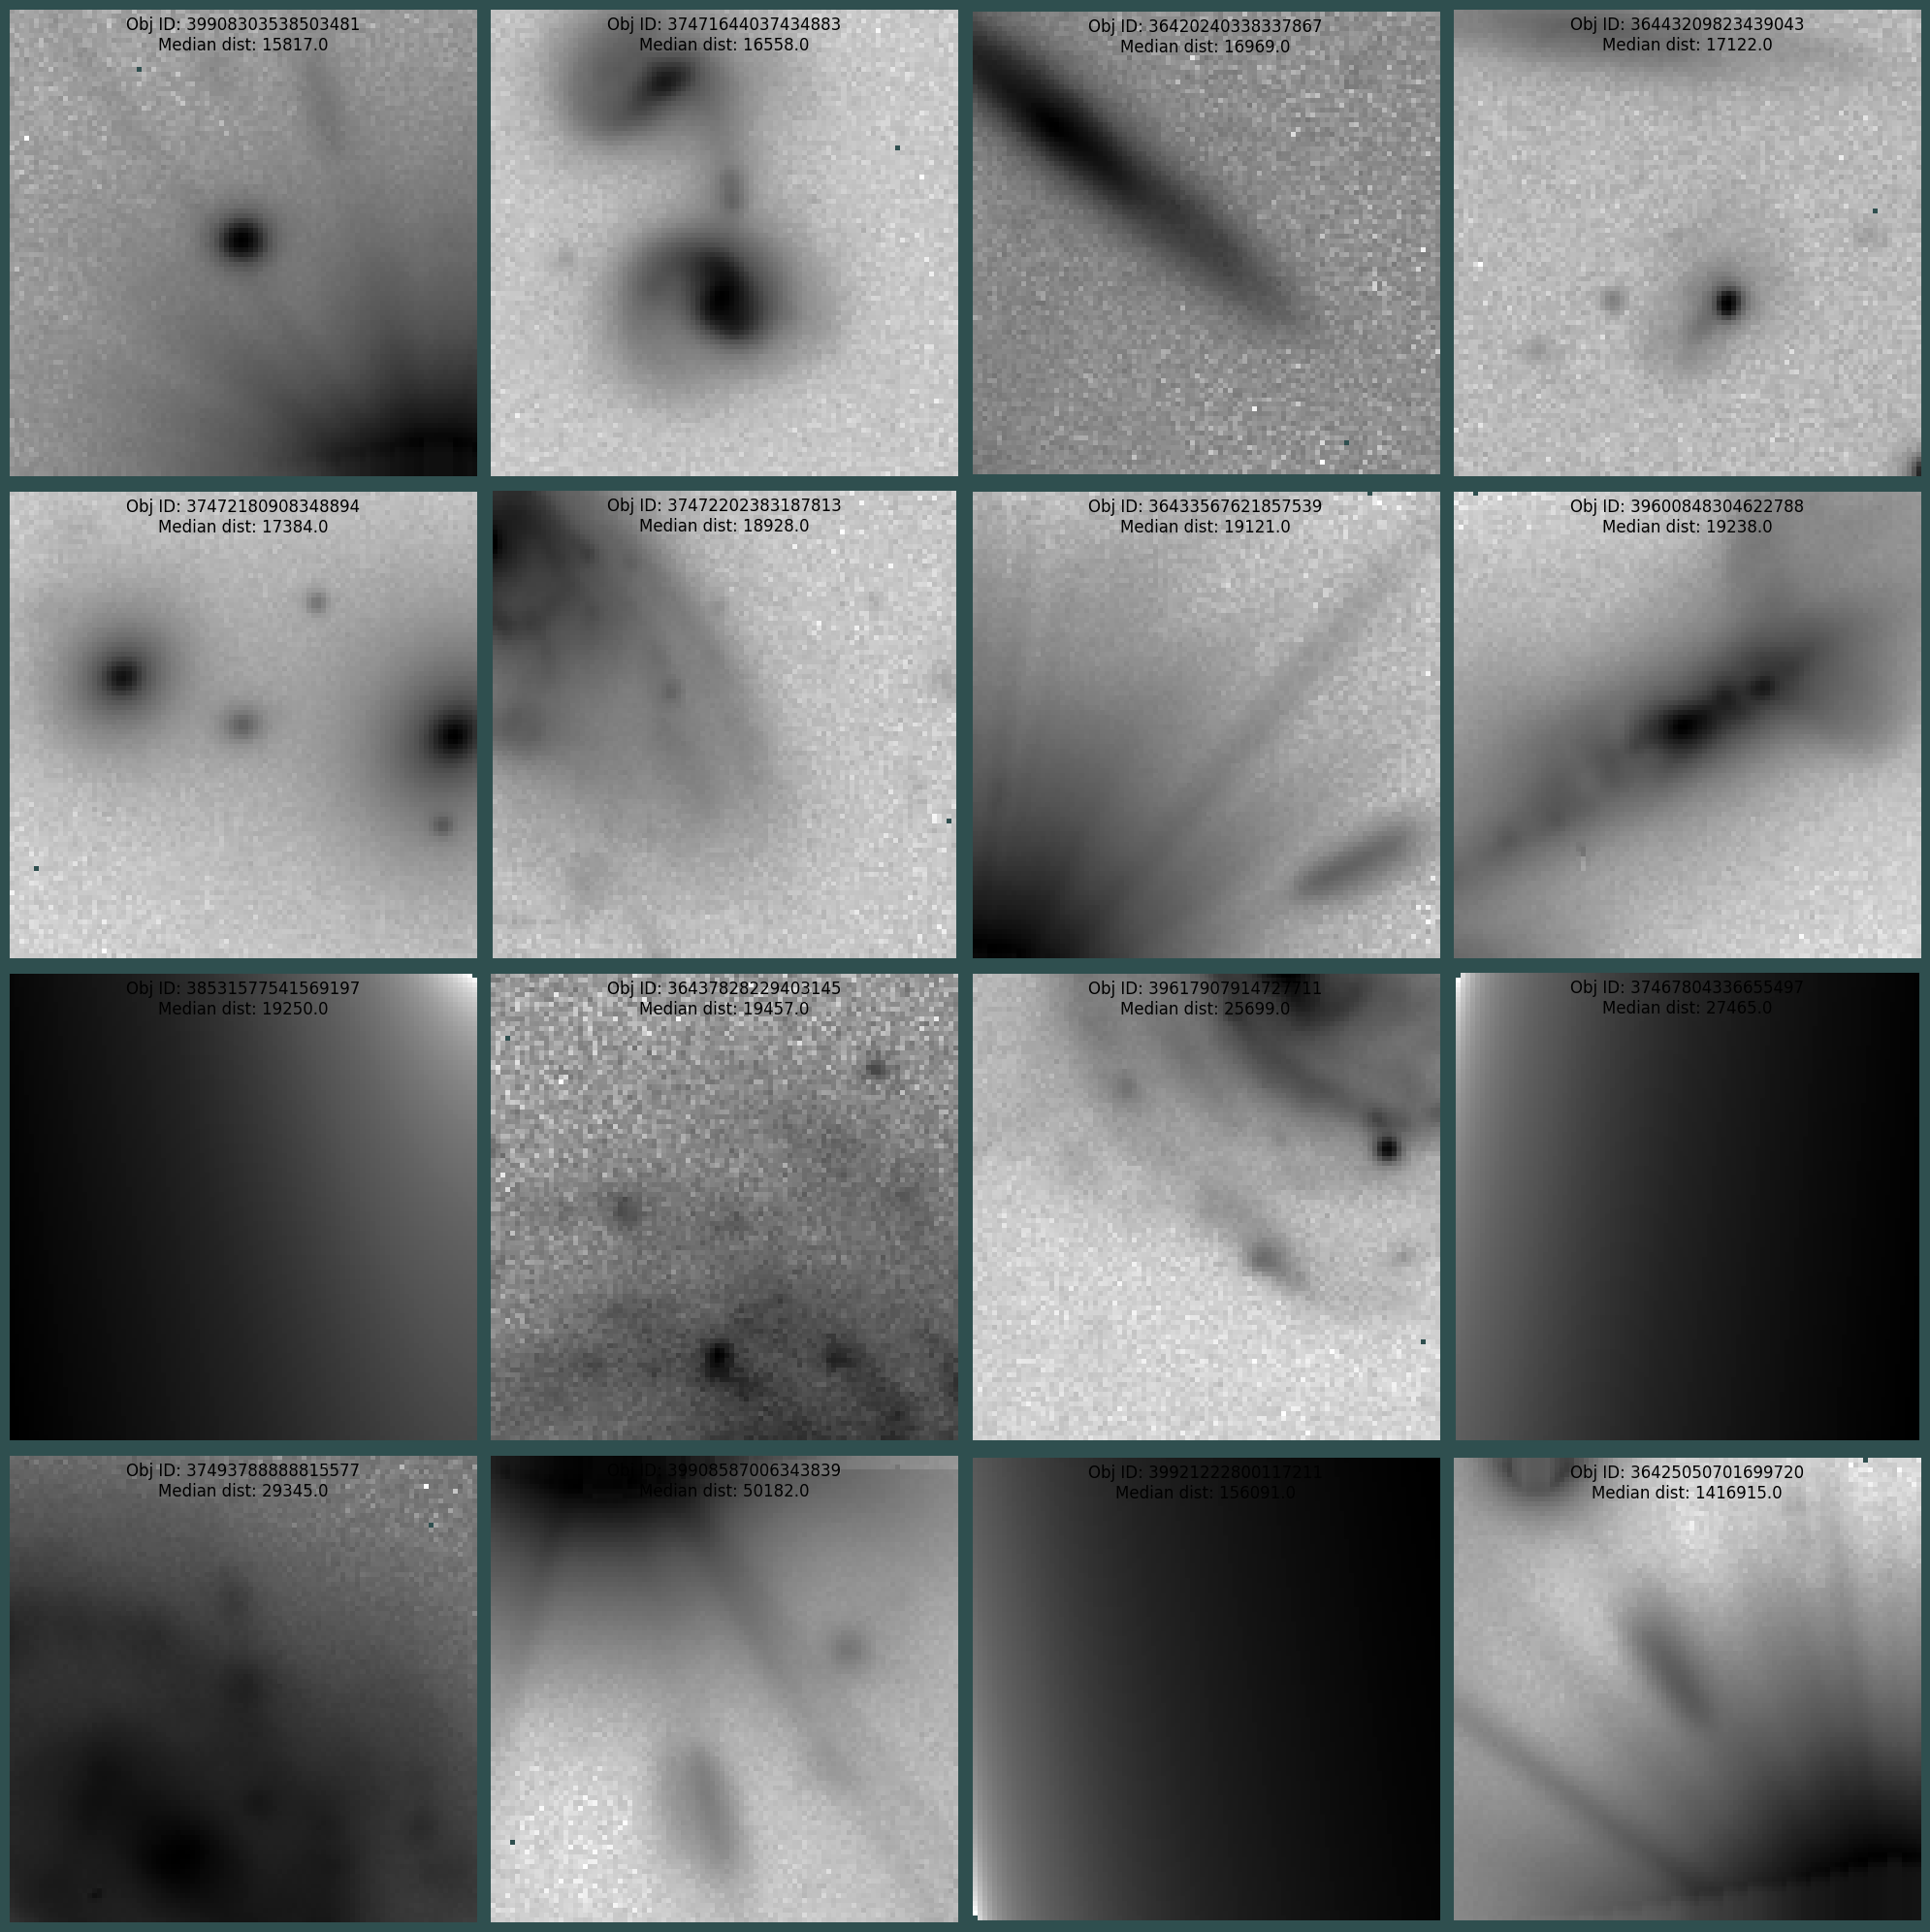

In [ ]:
plot_grid(sorted_object[-16:])

## Examine an embedding

[2025-02-08 10:13:36,095 fibad.data_sets.inference_dataset:INFO] Using most recent results dir /home/drew/code/fibad/docs/pre_executed/results/20250204-161602-infer-A4Hx for lookup. Use the [results] inference_dir config to set a directory or pass it to this verb.
/home/drew/miniconda3/envs/fibad/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/drew/miniconda3/envs/fibad/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/drew/miniconda3/envs/fibad/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


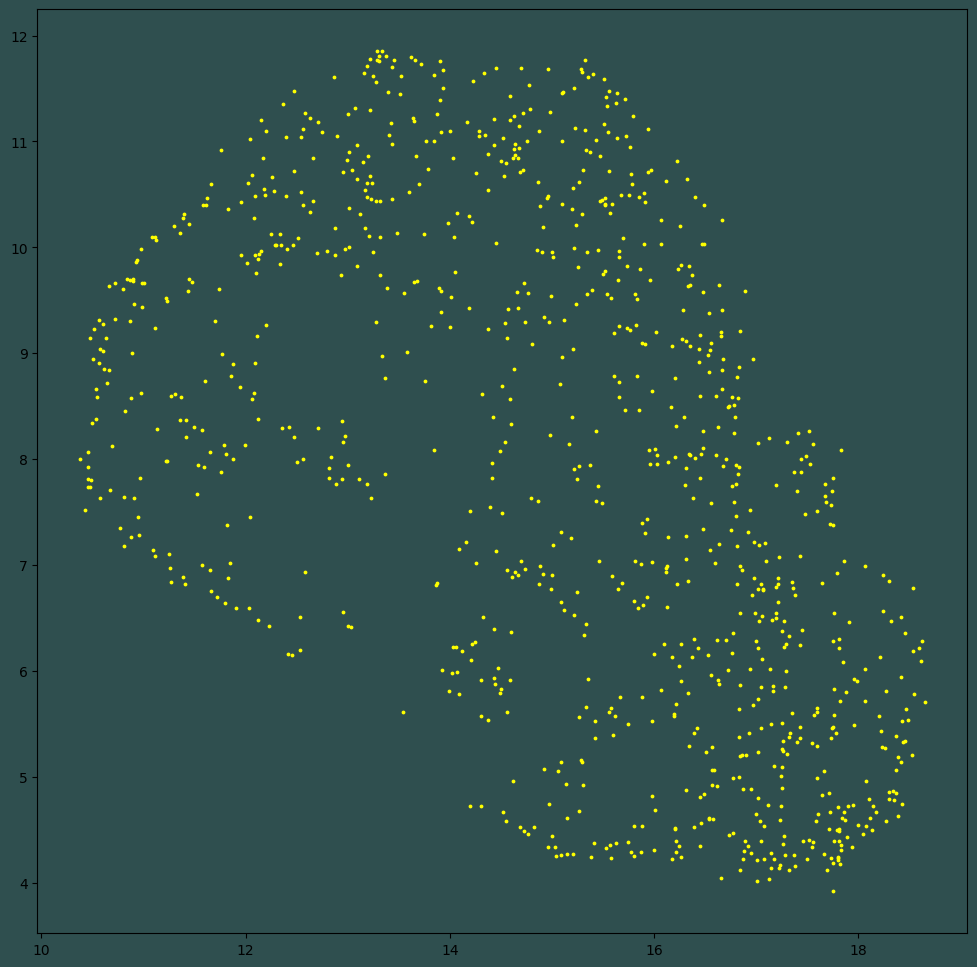

In [6]:
f.umap()
plot_umap(find_most_recent_results_dir(f.config, "umap"))

Here we are using the output of the latest inference run to inform a UMAP fitter and then plot the resulting lower dimensional space.
With only about 1000 samples, it's hard to visually identify obvious groupings in the 2D space.

While fitting and transforming is made fairly straightforward with the `umap-learn` API, additional data plumbing is provided by FIBAD.
We ensure that file output of the inference step allows for efficient fitting and transformation with UMAP and all of the data plumbing to read from inference and write results is taken care of.

To support further exploration of the embedding space, FIBAD includes an early implementation of an interactive visualization tool.

## Interactive visualization

[2025-02-08 10:23:12,676 fibad.data_sets.inference_dataset:INFO] Using most recent results dir /home/drew/code/fibad/docs/pre_executed/results/20250208-101336-umap-8Zdr for lookup. Use the [results] inference_dir config to set a directory or pass it to this verb.


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
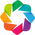

BokehModel(combine_events=True, render_bundle={'docs_json': {'643353da-c9de-4d1e-aad4-985808315a9b': {'version…

In [8]:
f.visualize(width=1000, height=1000)

The FIBAD visualization tooling utilizes Holoviews, Datashader as well as an efficient tree structure to be able to display millions of points.
It allows for panning, zooming as well as lasso and box selections.
When selecting points, the resulting object ids are displayed are displayed in the associated table.

While this is an early version of interactive visualization, it has been scaled up to millions of data points.
The next steps for this tooling will be to support deeper interactivity, namely:
-  Automatically displaying the object selected in the table
-  Leveraging the vector db to identify similar objects
-  Supporting three dimensional UMAP output


This visualization runs in a notebook but when rendered to HTML (for demonstration or documentation) the server backing the interactive visual isn't packaged with the rendering. If the cell above was run locally, the resulting UI would look similar to the following screen shot.

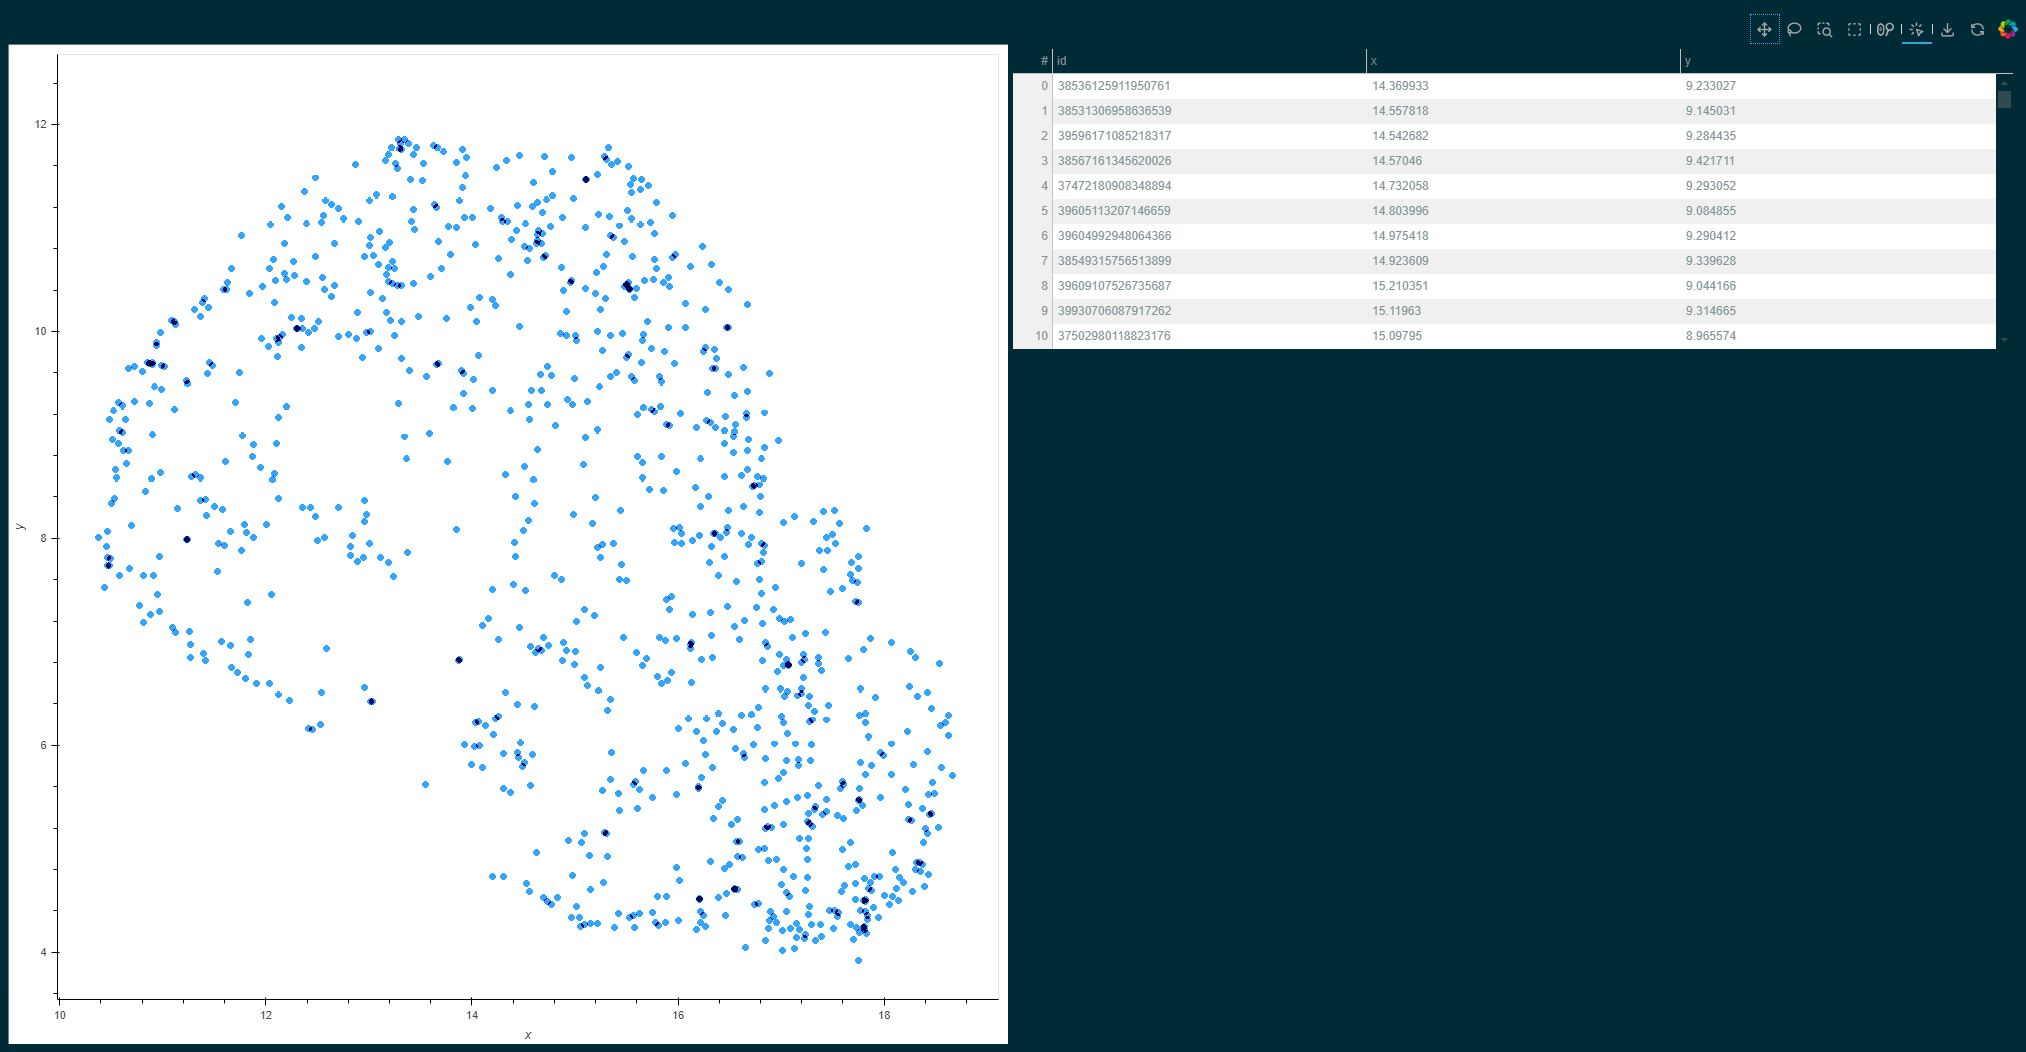


In [ ]:
mlflow_ui_process.terminate()